In [1]:
# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add to sys.path
sys.path.insert(0, parent_dir)


In [2]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'gmm_exp' in c['name'] 
        and c['config']['experiment']['latent_dim'] == 32
        and c['config']['experiment']['hidden_dim'] == 128
        and c['config']['dataset']['prior_mu'] == [0, 5]
        and hasattr(c['config']['encoder'], 'layers')
        and c['config']['encoder']['layers'] == 4 
]   



In [3]:
cfgs

[{'name': 'gmm_exp_306baf7263269f1374ae4db9f2aa993a',
  'dir': '../outputs/gmm_exp_306baf7263269f1374ae4db9f2aa993a',
  'config': {'dataset': {'_target_': 'datasets.distribution_datasets.MultivariateNormalDistributionDataset', 'n_sets': 10000, 'set_size': '${experiment.set_size}', 'data_shape': [2], 'seed': '${seed}', 'prior_mu': [0, 5], 'prior_cov_df': 10, 'prior_cov_scale': 1}, 'encoder': {'_target_': 'encoder.encoders.DistributionEncoderResNet', 'in_dim': '${dataset.data_shape[0]}', 'latent_dim': '${experiment.latent_dim}', 'hidden_dim': '${experiment.hidden_dim}', 'set_size': '${experiment.set_size}', 'layers': 4, 'fc_layers': 2}, 'model': {'_target_': 'layers.MLP', 'in_dims': [2, 32, 1], 'hidden_dim': 128, 'out_dim': 2, 'layers': 4}, 'generator': {'_target_': 'generator.ddpm.DDPM', 'model': '${model}', 'betas': [0.0001, 0.02], 'n_T': 400, 'drop_prob': 0.1, 'noise_shape': '${dataset.data_shape}'}, 'optimizer': {'_target_': 'torch.optim.Adam', '_partial_': True, 'lr': '${experiment.

In [4]:
cfgs = [cfgs[1]]

In [5]:
import hydra
# load + prep dataset
def prepare_dataset_and_mixer(cfg, set_size=None, n_sets=None, n_mixed_sets=None):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    if set_size is not None:
        cfg['dataset']['set_size'] = set_size
    if n_sets is not None:
        cfg['dataset']['n_sets'] = n_sets
    if n_mixed_sets is not None:
        cfg['mixer']['n_mixed_sets'] = n_mixed_sets
    dataset = hydra.utils.instantiate(cfg['dataset'])
    mixer = hydra.utils.instantiate(cfg['mixer'])
    return dataset, mixer


# load encoder and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

enc, gen = load_model(cfgs[0]['config'], cfgs[0]['dir'], device)


In [6]:
from torch.utils.data import DataLoader
ds, mx = prepare_dataset_and_mixer(cfgs[0]['config'], set_size=1_000_000, n_sets=100, n_mixed_sets=1)
dl = DataLoader(ds, batch_size=3, shuffle=False, collate_fn=mx.collate_fn)

In [7]:
dl_iter = iter(dl)
gmm_s = next(dl_iter)
gmm_t = next(dl_iter)

gmm_s = next(dl_iter)
gmm_t = next(dl_iter)

gmm_s = next(dl_iter)
gmm_t = next(dl_iter)

gmm_t = next(dl_iter)
gmm_s = next(dl_iter)

gmm_s = next(dl_iter)
gmm_s = next(dl_iter)

gmm_s = next(dl_iter)
gmm_s = next(dl_iter)

gmm_s = next(dl_iter)

In [8]:
gmm_s['mean'].shape

torch.Size([3, 2])

In [69]:
import numpy as np
import torch
samples_s = gmm_s['samples'].squeeze()
samples_t = gmm_t['samples'].squeeze()
lat = enc(torch.from_numpy(np.concatenate([samples_s[None, :500_000, :], samples_t[None, :500_000, :]], axis=0)).float().to(device))
resample = gen.sample(lat, 1_000_000, return_trajectory=False)
# linearly interpolate between the two points
lat_interp = lat[0] + (lat[1] - lat[0]) * torch.linspace(0, 1, 10)[:, None].to(device)
resample = gen.sample(lat_interp, 1_000_000, return_trajectory=False)


Text(0.5, 1.0, 'Resampled Distribution')

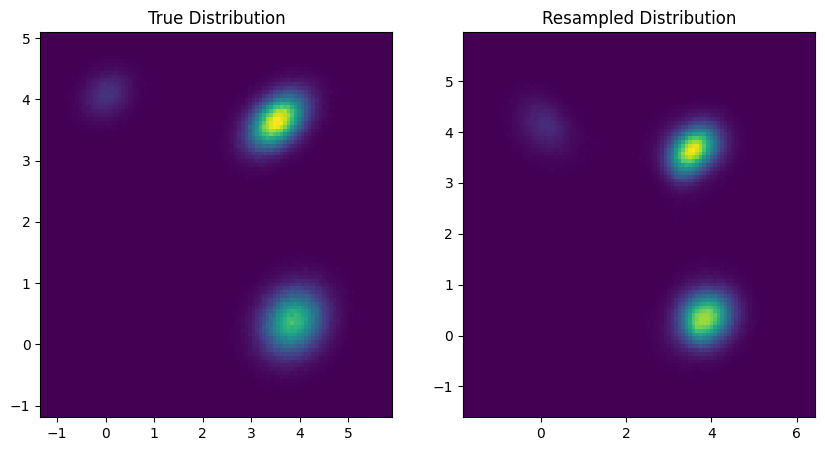

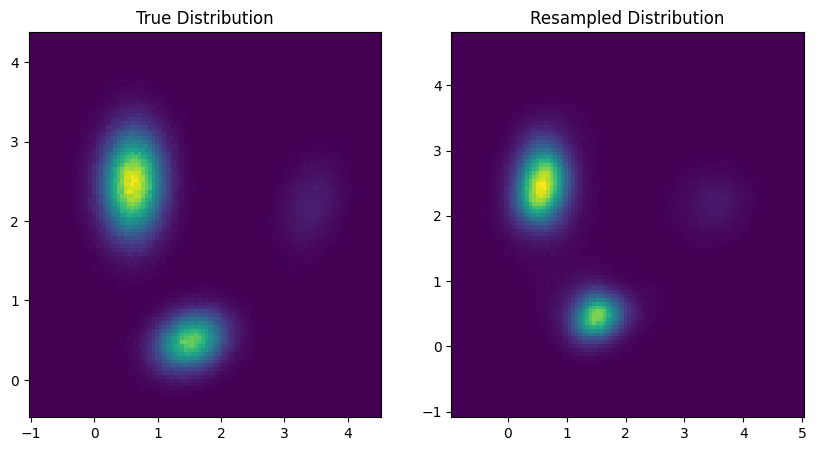

In [70]:
from matplotlib import pyplot as plt

# create subplots

# lets use a density plot instead of a scatter plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist2d(samples_s[:, 0], samples_s[:, 1], bins=100, density=True)
axs[1].hist2d(resample[0, :, 0].cpu().numpy(), resample[0, :, 1].cpu().numpy(), bins=100, density=True)
axs[0].set_title('True Distribution')
axs[1].set_title('Resampled Distribution')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist2d(samples_t[:, 0], samples_t[:, 1], bins=100, density=True)
axs[1].hist2d(resample[-1, :, 0].cpu().numpy(), resample[-1, :, 1].cpu().numpy(), bins=100, density=True)
axs[0].set_title('True Distribution')
axs[1].set_title('Resampled Distribution')



In [74]:
from utils.gmm_utils import optimize_gmm


def generate_ot_trajectory(
        mean1, cov1, weights1, mean2, cov2, weights2, 
        n_steps=10, lr=1e-4, n_gd_its=100, use_natural_gradient=False
    ):
    """
    Generate the correct Optimal Transport trajectory between two Gaussian distributions.
    
    Parameters:
    -----------
    mean1 : array-like
        Initial mean (2D vector)
    cov1 : array-like
        Initial covariance matrix (2x2)
    mean2: array-like
        Final mean (2D vector)
    cov2 : array-like
        Final covariance matrix (2x2)
    n_steps : int
        Number of interpolation steps
        
    Returns:
    --------
    means : array-like
        List of interpolated means
    covs : array-like
        List of interpolated covariance matrices
    """
    m_s = torch.tensor(mean1, requires_grad=True)
    C_s = torch.tensor(cov1, requires_grad=True)
    w_s = torch.tensor(weights1, requires_grad=True)
    m_t = torch.tensor(mean2, requires_grad=True)
    C_t = torch.tensor(cov2, requires_grad=True)
    w_t = torch.tensor(weights2, requires_grad=True)

    ot_means, ot_covs, ot_weights, ot_losses = optimize_gmm(
        m_s, m_t, C_s, C_t, w_s, w_t, n_gd_its, lr, use_natural_gradient=use_natural_gradient
    )
 
    # get 10 steps evenly spaced from the trajectory of 101 points using indices
    # indices = np.linspace(0, n_gd_its, n_steps).astype(int)
    # ot_means = ot_means[indices]
    # ot_covs = ot_covs[indices]
    # ot_weights = ot_weights[indices]
    return ot_means, ot_covs, ot_weights, ot_losses

ot_means, ot_covs, ot_weights, ot_losses = generate_ot_trajectory(
    gmm_s['mean'].squeeze(), gmm_s['cov'].squeeze(), gmm_s['weights'].squeeze(), 
    gmm_t['mean'].squeeze(), gmm_t['cov'].squeeze(), gmm_t['weights'].squeeze(),
    lr=1e-3, n_gd_its=10_000, use_natural_gradient=True, n_steps=10
)




/tmp/ipykernel_2214955/1145557984.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m_s = torch.tensor(mean1, requires_grad=True)
/tmp/ipykernel_2214955/1145557984.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  C_s = torch.tensor(cov1, requires_grad=True)
/tmp/ipykernel_2214955/1145557984.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_s = torch.tensor(weights1, requires_grad=True)
/tmp/ipykernel_2214955/1145557984.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() o

In [75]:
# Select points uniformly spaced in OT distance (time)
# First compute the cumulative loss change (monotonically decreasing)
# We reverse the losses since they decrease over time, and we want to measure progress
reversed_losses = ot_losses.max() - ot_losses
cumulative_progress = reversed_losses / reversed_losses.max()  # Normalize to [0,1]

# Select indices that correspond to uniform spacing in cumulative progress
target_progress = np.linspace(0, 1, 10)
selected_indices = []

for progress in target_progress:
    # Find the index with the closest progress value
    idx = np.argmin(np.abs(cumulative_progress - progress))
    selected_indices.append(idx)

# Ensure we include the final state
if selected_indices[-1] != len(ot_means) - 1:
    selected_indices[-1] = len(ot_means) - 1

# Extract the selected points
ot_means_ = ot_means[selected_indices]
ot_covs_ = ot_covs[selected_indices]
ot_weights_ = ot_weights[selected_indices]

In [77]:
from utils.gmm_utils import fit_gmm_batch

resample_means, resample_covs, resample_weights = fit_gmm_batch(resample.cpu().numpy(), ot_means_, ot_covs_, ot_weights_)



Fit GMM for mixture 0
Fit GMM for mixture 1
Fit GMM for mixture 2
Fit GMM for mixture 3
Fit GMM for mixture 4
Fit GMM for mixture 5
Fit GMM for mixture 6
Fit GMM for mixture 7
Fit GMM for mixture 8
Fit GMM for mixture 9


(<Figure size 1500x600 with 3 Axes>,
 (<Axes: xlabel='x', ylabel='y'>,
  <Axes: title={'center': 'Weight Simplex Trajectory'}>))

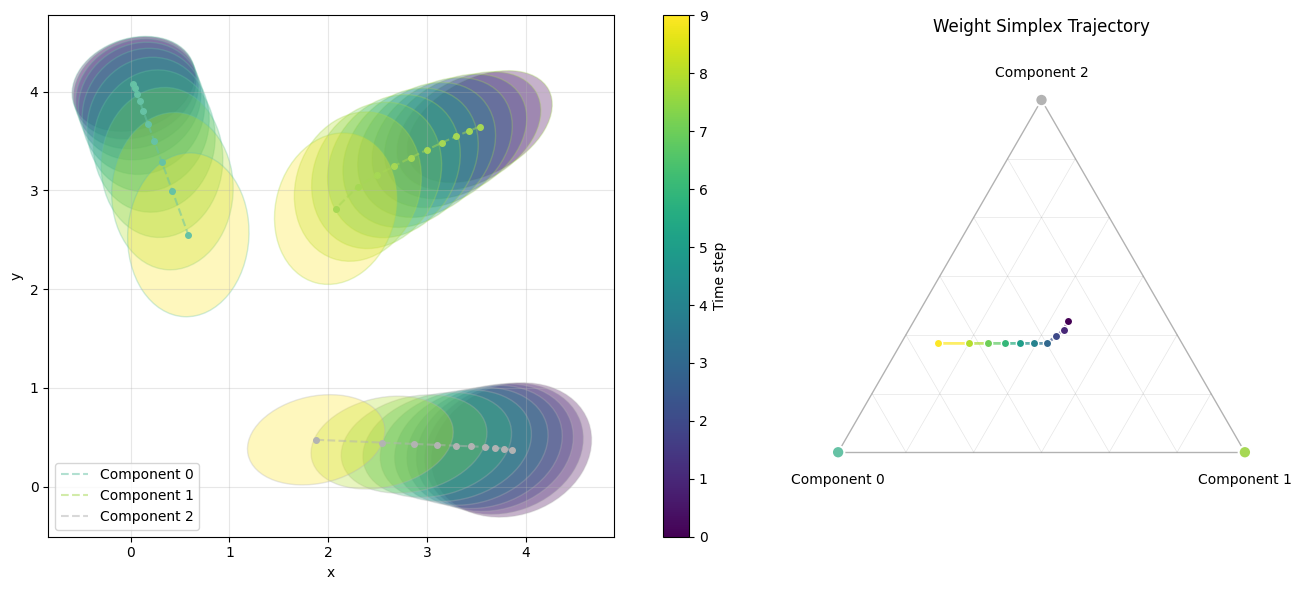

In [76]:
from utils.gmm_utils import plot_gmm_trajectory

plot_gmm_trajectory(ot_means_, ot_covs_, ot_weights_)
# plot_gmm_trajectory(resample_means, resample_covs, resample_weights)

(<Figure size 1500x600 with 3 Axes>,
 (<Axes: xlabel='x', ylabel='y'>,
  <Axes: title={'center': 'Weight Simplex Trajectory'}>))

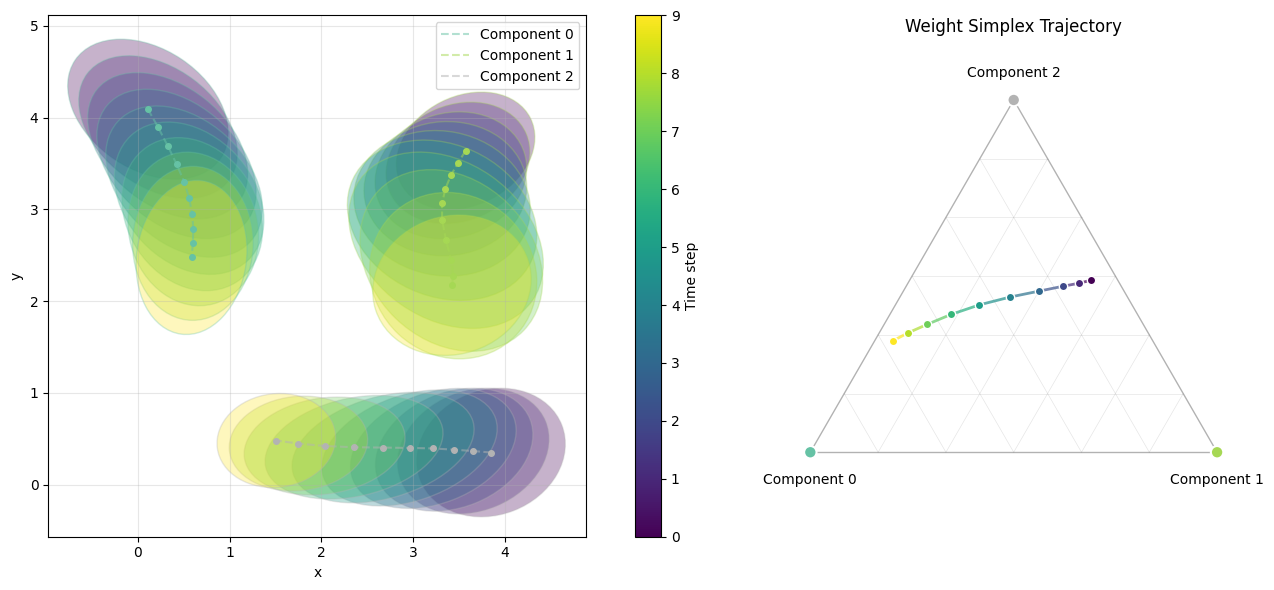

In [78]:
plot_gmm_trajectory(resample_means, resample_covs, resample_weights)